In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
import shapely.geometry as sg
import datetime as dt
from matplotlib import cm
from matplotlib.lines import Line2D
import json

In [2]:

df = pd.read_json("2020_APRIL.json")



def drop_rows(df, first_json_key):
    indexNames = df[ df.timelineObjects.apply(lambda x: list(x)[0]==first_json_key) ].index
    df.drop(indexNames , inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df


In [3]:
def parse_json(json):
    
    
    points = [sg.Point(xy) for xy in zip(json.timelineObjects.apply(lambda x: x['placeVisit']['location']["longitudeE7"] / 10000000),
                                        json.timelineObjects.apply(lambda x: x['placeVisit']['location']["latitudeE7"] / 10000000))]
    
    df = gp.GeoDataFrame(geometry=points)
    locations = json.timelineObjects
    df["timestamp"] = locations.apply(lambda x: pd.to_datetime(x['placeVisit']['duration']["startTimestampMs"], unit='ms'))

    return df
 
    
clean_json_df = drop_rows(pd.read_json("2020_APRIL.json"), 'activitySegment')

%time df = parse_json(clean_json_df)

Wall time: 210 ms


In [4]:
world = gp.read_file('mosbld\mosbld.shp')
 
def draw_map(df, box):
    box_only = df[df.geometry.within(box)]
    minx, miny, maxx, maxy = box.bounds
    base = world.plot(color='white', edgecolor='silver', figsize=(16,16))
    base.set_xlim(minx, maxx)
    base.set_ylim(miny, maxy)
    ax = box_only.plot(ax=base, marker='o', markersize=8)


In [5]:
def seconds(timestamp):
    return timestamp.to_pydatetime().timestamp()
 
 
def calculate_pal(df2, cmap):
    min_ts = seconds(df2.timestamp.min())
    max_ts = seconds(df2.timestamp.max())
    return df2.timestamp.apply(lambda ts: cmap((seconds(ts) - min_ts) / (max_ts - min_ts))).tolist()
 
 
def compute_legend(df, ax, cmap, steps):
    vals = [x / (steps - 1) for x in range(steps)]
    custom_lines = [Line2D([0], [0], color=cmap(step), lw=4) for step in vals]
    labels = [df.timestamp.quantile(step).strftime("%Y-%m-%d") for step in vals]
    ax.legend(custom_lines, labels, loc="lower right")
    
 
def draw_map(df, box):
    box_only = df[df.geometry.within(box)]
    minx, miny, maxx, maxy = box.bounds
    base = world.plot(color='white', edgecolor='silver', figsize=(16,12))
    base.set_xlim(minx, maxx)
    base.set_ylim(miny, maxy)
    cmap = cm.get_cmap('viridis')
    pal = calculate_pal(box_only, cmap)
    ax = box_only.plot(ax=base, marker='o', c=pal, markersize=50)
    compute_legend(box_only, ax, cmap, 5)


Bad key "text.kerning_factor" on line 4 in
C:\Users\Lera\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


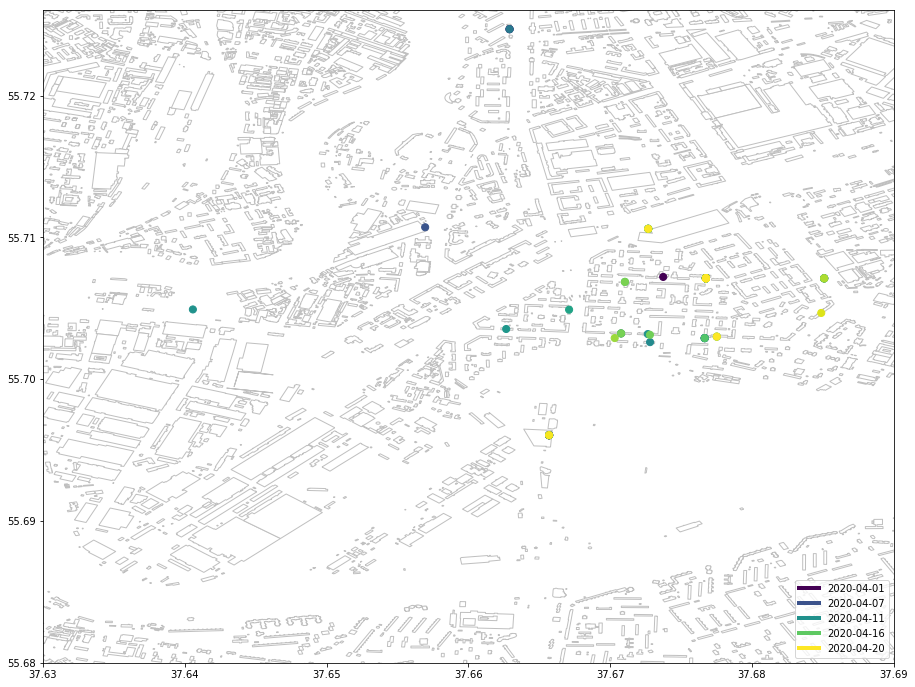

In [6]:
draw_map(df, sg.box(37.63, 55.68, 37.69, 55.726))


In [7]:
# draw_map(df, sg.box(-140, -20, 140, 70))
